The purpose of this notebook is to expose the causal structure underlying territorial polarisation in 1980-2020 France through canonical regression methods. The causal models we will discover will help discriminating between numerous qualitative assesments of this dynamics.

It is essentially based on the statsmodels library (Seabold, S., & Perktold, J. (2010). Statsmodels: Econometric and Statistical Modeling with Python. Proceedings of the 9th Python in Science Conference, 2010.).

In addition, we adapted the SESHAT regression methodology (Turchin, P. (2018). Fitting Dynamic Regression Models to Seshat Data. 35.), which was designed to handle both within- and between-areas interactions in cultural evolution, to adress similar dynamics in economic geography.

In [57]:
### Importing libraries ###

import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt

import geopandas as gpd
import statsmodels.api as sm


In [58]:
### Importing ZE1990 data ###

area_ZE1990 = pd.read_json("../Data processing/Output/area_ZE1990.json", typ="series")
dist_matrix_ZE1990 = pd.read_json("../Data processing/Output/dist_matrix_ZE1990.json")

dUC_timeseries_ZE1990 = pd.read_json("../Data processing/Output/dUC_timeseries_ZE1990.json")
d1_timeseries_ZE1990 = pd.read_json("../Data processing/Output/d1_timeseries_ZE1990.json")
med_timeseries_ZE1990 = pd.read_json("../Data processing/Output/med_timeseries_ZE1990.json")
d9_timeseries_ZE1990 = pd.read_json("../Data processing/Output/d9_timeseries_ZE1990.json")
moy_timeseries_ZE1990 = pd.read_json("../Data processing/Output/moy_timeseries_ZE1990.json")
intQ_timeseries_ZE1990 = pd.read_json("../Data processing/Output/intQ_timeseries_ZE1990.json")

In [59]:
### Importing ZE2010 data ###

area_ZE2010 = pd.read_json("../Data processing/Output/area_ZE2010.json", typ="series")
dist_matrix_ZE2010 = pd.read_json("../Data processing/Output/dist_matrix_ZE2010.json")

dUC_timeseries_ZE2010 = pd.read_json("../Data processing/Output/dUC_timeseries_ZE2010.json")
d1_timeseries_ZE2010 = pd.read_json("../Data processing/Output/d1_timeseries_ZE2010.json")
med_timeseries_ZE2010 = pd.read_json("../Data processing/Output/med_timeseries_ZE2010.json")
d9_timeseries_ZE2010 = pd.read_json("../Data processing/Output/d9_timeseries_ZE2010.json")
## moy_timeseries_ZE2010 = pd.read_json("../Data processing/Output/moy_timeseries_ZE2010.json")
intQ_timeseries_ZE2010 = pd.read_json("../Data processing/Output/intQ_timeseries_ZE2010.json")

tert_timeseries_ZE2010 = pd.read_json("../Data processing/Output/tert_timeseries_ZE2010.json")


In [60]:
### Importing other data

foreigndebt_timeseries = pd.read_json("../Data processing/Output/foreigndebt_timeseries.json")
foreigncapitals_timeseries = pd.read_json("../Data processing/Output/foreigncapitals_timeseries.json")

We will below implement a global prediction of polarisation levels from financiarisation and productivity disparities

In [61]:
### Extracting D1 and D9 index for ZE1990 and ZE2010 data

def D1D9_polarisation(med_timeseries, bottom_timeseries, top_timeseries, D1D9_number):
    top_index = med_timeseries.mean().nlargest(D1D9_number).index
    bottom_index = med_timeseries.mean().nsmallest(D1D9_number).index
    
    D1D9_pol = np.log(top_timeseries[top_index]).mean(axis=1) -  np.log(bottom_timeseries[bottom_index]).mean(axis=1)
    
    return(D1D9_pol)

D1D9_number = 25

In [78]:
### OLS regression on static data

    ## Defining exog
X = pd.DataFrame(index = range(1999, 2018))

X["Intercept"] = 1
X["Dette étrangère"] = foreigndebt_timeseries
X["Capitaux étrangers"] = foreigncapitals_timeseries
X["Polarisation de la composition sectorielle"] = D1D9_polarisation(med_timeseries_ZE2010, tert_timeseries_ZE2010, tert_timeseries_ZE2010, D1D9_number)

    ## Defining endog
y = pd.DataFrame(index = range(2001,2018))

y["Polarisation des revenus"] = pd.concat([D1D9_polarisation(med_timeseries_ZE1990, d1_timeseries_ZE1990, d9_timeseries_ZE1990, D1D9_number), D1D9_polarisation(med_timeseries_ZE2010, d1_timeseries_ZE2010, d9_timeseries_ZE2010, D1D9_number)])

    ## Regressing
results = sm.OLS(y, X.loc[y.index]).fit()

print(results.summary())

                               OLS Regression Results                               
Dep. Variable:     Polarisation des revenus   R-squared:                       0.623
Model:                                  OLS   Adj. R-squared:                  0.536
Method:                       Least Squares   F-statistic:                     7.150
Date:                      Sun, 02 Aug 2020   Prob (F-statistic):            0.00442
Time:                              13:00:31   Log-Likelihood:                 42.410
No. Observations:                        17   AIC:                            -76.82
Df Residuals:                            13   BIC:                            -73.49
Df Model:                                 3                                         
Covariance Type:                  nonrobust                                         
                                                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------

/home/avel/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1450: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  "anyway, n=%i" % int(n))


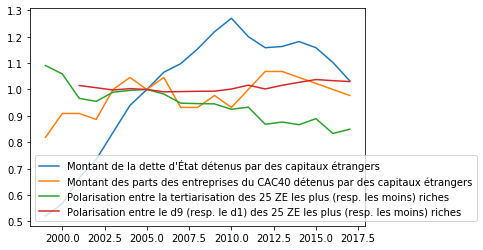

In [65]:
### Drawing data for static regression

fig = plt.figure()

plt.plot(X["Dette étrangère"]/X["Dette étrangère"].loc[2005], label="Montant de la dette d'État détenus par des capitaux étrangers")
plt.plot(X["Capitaux étrangers"]/X["Capitaux étrangers"].loc[2005], label="Montant des parts des entreprises du CAC40 détenus par des capitaux étrangers")
plt.plot(X["Polarisation de la composition sectorielle"]/X["Polarisation de la composition sectorielle"].loc[2005], label="Polarisation entre la tertiarisation des " + str(D1D9_number) + " ZE les plus (resp. les moins) riches")
plt.plot(y["Polarisation des revenus"]/y["Polarisation des revenus"].loc[2005], label="Polarisation entre le d9 (resp. le d1) des " + str(D1D9_number) + " ZE les plus (resp. les moins) riches")

plt.legend()

plt.savefig("Global regression variables.png")
plt.show()

In [77]:
### OLS regression on dynamic data


    ## Defining exog
X = pd.DataFrame(index = range(1999, 2018))

X["Intercept"] = 1
X["Dette étrangère"] = foreigndebt_timeseries
X["Capitaux étrangers"] = foreigncapitals_timeseries
X["Polarisation de la composition sectorielle"] = D1D9_polarisation(med_timeseries_ZE2010, tert_timeseries_ZE2010, tert_timeseries_ZE2010, D1D9_number)
X["Polarisation des revenus"] = pd.concat([D1D9_polarisation(med_timeseries_ZE1990, d1_timeseries_ZE1990, d9_timeseries_ZE1990, D1D9_number), D1D9_polarisation(med_timeseries_ZE2010, d1_timeseries_ZE2010, d9_timeseries_ZE2010, D1D9_number)])

X = X.dropna()
    ## Defining endog
y = pd.DataFrame(index = range(1999,2018))

y["Variation annuelle de la polarisation des revenus"] = X["Polarisation de la composition sectorielle"].apply(lambda x: np.log(x)).diff()
y = y.shift(-1).dropna()


    ## Regressing
results = sm.OLS(y, X.loc[y.index]).fit()

print(results.summary())

                                            OLS Regression Results                                           
Dep. Variable:     Variation annuelle de la polarisation des revenus   R-squared:                       0.482
Model:                                                           OLS   Adj. R-squared:                  0.294
Method:                                                Least Squares   F-statistic:                     2.562
Date:                                               Sun, 02 Aug 2020   Prob (F-statistic):             0.0978
Time:                                                       12:59:50   Log-Likelihood:                 39.329
No. Observations:                                                 16   AIC:                            -68.66
Df Residuals:                                                     11   BIC:                            -64.79
Df Model:                                                          4                                         
Covariance

/home/avel/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1450: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  "anyway, n=%i" % int(n))
